In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageDraw
import requests
from pycocotools.coco import COCO
from pathlib import Path
import cv2
import torch
import os
import sys
from torch import nn, Tensor
# from torchvision import transforms
import torchvision
# from torchvision.transforms import functional as F
# from torchvision.transforms import transforms as T
import mrcnn

# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = './Mask_RCNN'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
# import mrcnn.utils as utils
from mrcnn import visualize
# import mrcnn.model as modellib
from torchvision.ops import box_convert
import albumentations
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
import wandb
# wandb.init(project="my-test-project", entity="kolor200")

In [3]:
# wandb.finish()

In [4]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

# Composes transforms 
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# List of transformations:

# Transforms data into torch Tensors
class ToTensor(nn.Module):
    def forward(self, image, target):
#         print(image.dtype, image.shape)
        image = torchvision.transforms.functional.pil_to_tensor(image)
        image = torchvision.transforms.functional.convert_image_dtype(image)
#         image = torchvision.transforms.functional.convert_image_dtype(image)
        
        return image, target

# Not needed performed by transformation seen above
class ConvertImageDtype(nn.Module):
    def __init__(self, dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(self, image, target):
        image = torchvision.transforms.functional.convert_image_dtype(image, self.dtype)
        return image, target

# Random Horizontal Flip
class RandomHorizontalFlip(torchvision.transforms.transforms.RandomHorizontalFlip):
    def forward(self, image, target):
        if torch.rand(1) < self.p:
            image = torchvision.transforms.functional.hflip(image)
            if target is not None:
                width, _ = torchvision.transforms.functional.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - target["boxes"][:, [2, 0]]
                if "masks" in target:
                    target["masks"] = target["masks"].flip(-1)
        return image, target
    

class RandomImageEqualization(torchvision.transforms.transforms.RandomEqualize):
    def forward(self, image, target):
        if torch.rand(1) < self.p:
            image = torchvision.transforms.functional.equalize(image)
        return image, target


class RandomGaussianBlur(torchvision.transforms.transforms.RandomEqualize):
    def forward(self, image, target):
        if torch.rand(1) < self.p:
            image = torchvision.transforms.functional.gaussian_blur(image, kernel_size=(5, 9), sigma=(0.1, 5))
        return image, target

# This function applies random rotation, using wonderful library albumentations.ai
class RandomRotation(nn.Module):
    def __init__(self, p) -> None:
        super().__init__()
        self.p = p
        
    def forward(self, image, target):
        if torch.rand(1) < self.p:
            
            transform = albumentations.Compose([
                albumentations.Rotate(p=0.5, limit=(-90, 90), mask_value=0)
            ], bbox_params=albumentations.BboxParams(format='pascal_voc',  
                                                     min_area=1024, 
                                                     min_visibility=0.1))
              
            image = np.asarray(image)
            list_of_masks = []
            for mask in target["masks"]:
                list_of_masks.append(np.asarray(mask))
            bboxes = list(target["boxes"])
            
            class_labels = list(np.asarray(target["labels"]))
            new_bboxes =[]
            for bbox, class_label in zip(bboxes, class_labels):
                bbox = list(np.asarray(bbox))
                bbox.append(class_label)
                new_bboxes.append(bbox)
            
            transformed = transform(image=image, masks=list_of_masks, bboxes=new_bboxes, class_labels=class_labels)
            
            transformed_image = transformed['image']
            image = transformed_image
            
            transformed_bboxes = transformed['bboxes']
            final_bboxes = []
            for bbox in transformed_bboxes:
                final_bboxes.append(bbox[:-1])
            transformed_bboxes = torch.as_tensor(final_bboxes, dtype=torch.float32)
            target["boxes"] = transformed_bboxes
            
            transformed_masks = transformed['masks']
            transformed_masks = np.dstack(transformed_masks)
            transformed_masks = torch.as_tensor(np.copy(transformed_masks), dtype=torch.uint8)
            transformed_masks = torch.permute(transformed_masks, (2,0,1))
            target["masks"] = transformed_masks
            
        return Image.fromarray(image), target
    
def get_train_transforms():
    transforms = []
#     transforms.append(RandomRotation(1))
    transforms.append(ToTensor())
    transforms.append(ConvertImageDtype(torch.uint8))
    transforms.append(RandomHorizontalFlip(0.3))
    transforms.append(RandomImageEqualization(0.2))
    transforms.append(RandomGaussianBlur(0.2))
    transforms.append(ConvertImageDtype(torch.float32))
    return Compose(transforms)

def get_val_transforms():
    transforms = []
    transforms.append(ToTensor())
    return Compose(transforms)

# dataset = LiveCellDataset("LiveCellDataset", get_train_transforms())
# image, target = dataset.__getitem__(14)
# print(image.shape, image.dtype)
# print(target['masks'].shape, target['masks'].dtype)
# print('labels', target['labels'], target['labels'].dtype)
# print('boxes:', target['boxes'].shape, target['boxes'].dtype) #correct
# print('iscrowd:', target['iscrowd'], target['iscrowd'].dtype)
# print('image_id:', target['image_id'], target['image_id'].dtype)
# print('area:', target['area'], target['area'].dtype)

In [5]:
class LiveCellDataset(torch.utils.data.Dataset): #torch.utils.data.Dataset
    def __init__(self, root, transforms, annotation_file_path, image_path_path):
        self.root = root
        self.transforms = transforms
        
        # Loading annotations here
        #self.coco_annotation = COCO(annotation_file="../data/TrashCan/instances_train_trashcan.json")
        #self.coco_annotation = COCO(annotation_file="../data/TrashCan/instances_val_trashcan.json")
        self.coco_annotation = COCO(annotation_file=annotation_file_path)
        self.image_path_path = image_path_path
        
        # Loading their ids, please note only one category!
        self.image_ids = self.coco_annotation.getImgIds(catIds=[self.coco_annotation.getCatIds()[0]])

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco_annotation.loadImgs([img_id])[0]
        img_file_name = img_info["file_name"]
        
        #img_path = Path("../data/TrashCan/train") / img_file_name
        #img_path = Path("../data/TrashCan/val") / img_file_name
        
        img_path = Path(self.image_path_path) / img_file_name

        
        img = Image.open(str(img_path)).convert("RGB")
#         display_image(img)
        
        ann_ids = self.coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco_annotation.loadAnns(ann_ids)
        
        target = self.get_target(anns, img_info, idx)
    
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            return img, target
        else:
            return ToTensor()(img, target)[0], target


    def get_target(self, annotations, image_info, idx):
        boxes = []
        labels = []
        masks = []
        area = []
        iscrowd = []
        
        image_id = torch.tensor([idx], dtype=torch.int64)
        
        for annotation in annotations:
            one_mask = self.coco_annotation.annToMask(annotation)
            masks.append(one_mask)
            
            labels.append(annotation['category_id'])
            
            bounding_box = annotation['bbox']
            boxes.append(bounding_box)
            
            _iscrowd = annotation['iscrowd']
            iscrowd.append(_iscrowd)
            
            _area = annotation['area']
            area.append(_area)
            
        masks = np.dstack(masks)
        masks = torch.as_tensor(np.copy(masks), dtype=torch.uint8)
        masks = torch.permute(masks, (2,0,1))
        
        labels = torch.as_tensor(labels, dtype=torch.int64)
    
        area = torch.as_tensor(area, dtype=torch.float64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        boxes = box_convert(boxes, in_fmt='xywh', out_fmt='xyxy')
        
        assert len(boxes) == len(iscrowd) == len(labels) == len(area)
        if not (len(boxes) == len(iscrowd) == len(labels) == len(area)):
            print(len(boxes), len(iscrowd), len(labels), len(area))
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return target

    def __len__(self):
        return len(self.image_ids)

# dataset = LiveCellDataset("LiveCellDataset", get_val_transforms(), '../data/TrashCan/instances_train_trashcan.json', 
#                                 "../data/TrashCan/train")
# image, target = dataset.__getitem__(15)
# print(image.shape, image.dtype)
# print(target['masks'].shape, target['masks'].dtype)
# print('labels', target['labels'], target['labels'].dtype)
# print('boxes:', target['boxes'].shape, target['boxes'].dtype) #correct
# print('iscrowd:', target['iscrowd'], target['iscrowd'].dtype)
# print('image_id:', target['image_id'], target['image_id'].dtype)
# print('area:', target['area'], target['area'].dtype)

In [6]:
# Source:
# https://github.com/pytorch/vision/tree/main/references/segmentation
import torch
import torchvision.models.detection.mask_rcnn
import utils_github.utils as utils
from utils_github.coco_eval import CocoEvaluator
from utils_github.coco_utils import get_coco_api_from_dataset
import math
import sys
import time
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
#     print("len(data_loader)/print_freq:", len(data_loader)/print_freq)
    metric_logger = utils.MetricLogger(delimiter="  ", epoch=epoch, test=True, 
                                       how_much=int(len(data_loader)/print_freq))
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        # print(targets)
        # print(targets.values)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
#             print("Moje", losses)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
#         print("Loss_dict_reduced", loss_dict_reduced)
#         print("Losses_reduced", losses_reduced)
        loss_value = losses_reduced.item()
#         print("Loss_value", loss_value)
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device, epoch):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ", epoch=epoch, test=False)
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
#     print("Averaged stats:", metric_logger)
#     print(metric_logger.meters)
#     wandb.log({"epoch": epoch,"validation_loss": metric_logger})
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_train = LiveCellDataset("LiveCellDataset", get_train_transforms(), 
                                '../data/TrashCan/instances_train_trashcan.json', 
                                "../data/TrashCan/train")

dataset_test = LiveCellDataset("LiveCellDataset", get_val_transforms(), 
'../data/TrashCan/instances_val_trashcan.json', 
"../data/TrashCan/val")

indices = torch.randperm(len(dataset_test)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[:30])

indices = torch.randperm(len(dataset_train)).tolist()
dataset_train = torch.utils.data.Subset(dataset_train, indices[:2100])
dataset_loader_train = torch.utils.data.DataLoader(
dataset_train, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

dataset_loader_test = torch.utils.data.DataLoader(
dataset_test, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

# image, target = dataset_test.__getitem__(15)
# print(image.shape, image.dtype)
# print(target['masks'].shape, target['masks'].dtype)
# print('labels', target['labels'], target['labels'].dtype)
# print('boxes:', target['boxes'].shape, target['boxes'].dtype) #correct
# print('iscrowd:', target['iscrowd'], target['iscrowd'].dtype)
# print('image_id:', target['image_id'], target['image_id'].dtype)
# print('area:', target['area'], target['area'].dtype)

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


In [8]:
# wandb.init(project="my-test-project", entity="kolor200")
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def main():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    # 1 + 22
    num_classes = 23
    model = get_model_instance_segmentation(num_classes)
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
    num_epochs = 10

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, dataset_loader_train, device, epoch, print_freq=10)
        if epoch % 3 == 0:
            print("Saving model")
            torch.save(model.state_dict(), f"models/{epoch}.model")
        lr_scheduler.step()
        # evaluate on the test dataset
#         evaluate(model, dataset_loader_test, device=device, epoch=epoch)
        
    evaluate(model, dataset_loader_test, device=device, epoch=epoch)
    torch.save(model.state_dict(), f"models/{num_epochs}.model")
    return model 
#     print("That's it!")
# model = main()

In [9]:
# wandb.finish()

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.36E-02


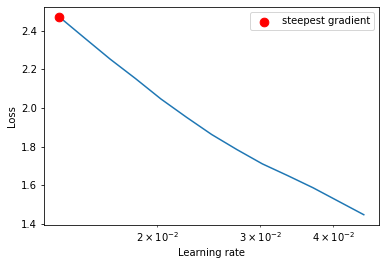

In [11]:
#https://github.com/davidtvs/pytorch-lr-finder
from torch_lr_finder import LRFinder
model = get_model_instance_segmentation(23)
model.eval()
criterion = nn.CrossEntropyLoss()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataset_loader_test, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()